# Downloading Dataset from Mega

## Installing Mega Library

In [1]:
%%capture
%pip install mega.py
%pip install patool

## Downloading Dataset from Mega Url

In [2]:
from mega import Mega
import os

# Mega url for the dataset.
data_url = 'https://mega.nz/file/5FhGkRjD#yFihfhr1RMHfPTffhPB4tQtJsnn_HBYFOSfqdPOrp78'
# Dataset folder path.
dataset_folder = 'dataset'
# Create the dataset folder.
os.makedirs(dataset_folder, exist_ok=True)
# Initiate Mega object.
mega = Mega()
# Download file specified in data_url to dataset folder.
dataset_path = mega.download_url(data_url, dataset_folder)

## Extracting Zip File

In [3]:
import patoolib
import glob

def get_last_file_in_folder(path: str):
  """Get the latest file inserted into a folder."""
  list_of_files = glob.glob(f'{path}/*') # * means all 
  latest_file = max(list_of_files, key=os.path.getctime)
  
  return latest_file


try:
  # Make sure it's an archive. 
  patoolib.get_archive_format(dataset_path)
  # Extract it.
  patoolib.extract_archive(str(dataset_path), outdir= dataset_folder)
  # Make a new location for dataset.
  dataset_path = get_last_file_in_folder(dataset_folder)
  print(f"[INFO] DATASET EXTRACTED AND READY; {dataset_path}")

except Exception as e: 
  dataset_path = str(dataset_path)
  print(f"[INFO] DATASET FOLDER READY; {dataset_path}")

patool: Extracting dataset/pixel-art-pinterest-030.zip ...
patool: running /usr/bin/7z x -odataset -- dataset/pixel-art-pinterest-030.zip
patool: ... dataset/pixel-art-pinterest-030.zip extracted to `dataset'.
[INFO] DATASET EXTRACTED AND READY; dataset/pixel-art-pinterest-030


# CLIP Model and Helper Functions

## CLIP Model Parameters

In [3]:
# Model type used in generating CLIP feature vectors.
MODEL_TYPE = 'ViT-B-32'
# Pretrained type for the model.
PRETRAINED = 'openai'

## Installing OpenCLIP Library.

In [8]:
%%capture
%pip install open-clip-torch

In [15]:
import hashlib
from PIL import Image
import torch
import open_clip

# Creating model, device and preprocess objects for CLIP. 
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_TYPE,pretrained = PRETRAINED)
model = model.to(device)


def compute_sha256(image: Image.Image) -> str: 
    """Compute the SHA256 of a PIL image. """
    return hashlib.sha256(image.tobytes()).hexdigest()


def compute_clip(image: Image.Image):
  """Get normalized clip feature vector for single image."""
  with torch.no_grad():
    image = preprocess(image).unsqueeze(0)
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features
  

def compute_image_bytes(image_path: str):
  file = open(image_path, "rb")
  return file.read()


# Manual Ranking Application

## Installing Widget Library

In [10]:
%%capture
%pip install ipywidgets==7.7.3

## JSON Object Initialization

In [6]:
JSON_IMAGE_PAIR_LIST = [] # This is the object will be converted into a json file for the dataset.

## Widget Implementation

In [7]:
import os
import random
import uuid
import json
import datetime
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

class QualityModelWidgets(object):

    def __init__(self) -> None:
        self.step = 0 
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()

    def __get_two_random_images(self):
      global dataset_path
      list_of_images = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) if file_name.endswith(('.png', '.jpeg', '.jpg', 'webp'))]
      return list_of_images[random.randint(0, len(list_of_images))] , list_of_images[random.randint(0, len(list_of_images))]

    def start(self):
        # Initial Images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        # Image widgets
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)
        # Image labels
        self.lbl_img_1 = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 20px ; font-weight: bold ; color:rgb(75,75,75)">1</p>')
        self.lbl_img_2 = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 20px ; font-weight: bold ; color:rgb(75,75,75)">2</p>')
        self.lbl_img_1.layout.height = '50px'
        self.lbl_img_2.layout.height = '50px'
        
        # Title label
        self.lbl_title_value = f'Quality Model App'
        self.lbl_title = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 24px ; font-weight: bold ; color:rgb(75,75,75)">{self.lbl_title_value}</p>')
        # Tagging User
        self.lbl_user = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75) ; height: 20px">Tagging User: </p>')
        self.txt_user = widgets.Text(value='', disabled=False)
        self.txt_user.layout.width = '250px'
        # Status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        self.lbl_status.layout.height = '50px'
        
        # Selection buttons
        self.btn_select_1 = widgets.Button(description = 'SELECT 1', icon='check', button_style = 'success')
        self.btn_select_1.style.button_color = 'rgb(30,144,255)'
        self.btn_select_2 = widgets.Button(description = 'SELECT 2', icon='check', button_style = 'success')
        self.btn_select_2.style.button_color = 'rgb(30,144,255)'
        # Skip button
        self.btn_skip = widgets.Button(description = 'SKIP')
        self.btn_skip.style.button_color = 'rgb(225,225,225)'
        # Layout
        self.box_layout = widgets.Layout(display='flex',
                                    flex_flow='row',
                                    justify_content = 'space-around',
                                    align_items='center',
                                    width='100%'
                                    )
        
        # binding skip button to skip function callback
        self.btn_skip.on_click(self.skip_pressed)
        # binding select button 1 and 2 to select function callback
        self.btn_select_1.on_click(self.select_pressed)
        self.btn_select_2.on_click(self.select_pressed)

        # Show widgets
        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )


    def get_2_rand_images (self, data_dict):
        # List of hashes (keys in data_dict)
        hash_list = list(data_dict.keys())
        # File 1
        hash_1 = random.choice(hash_list)
        file_path_1 = data_dict[hash_1]['file_path']
        file_name_1 = data_dict[hash_1]['file_name']
        with open(file_path_1, 'rb') as img_file_1:
            img_bytes_1 = img_file_1.read()
        # File 2
        hash_2 = random.choice(hash_list)
        file_path_2 = data_dict[hash_2]['file_path']
        file_name_2 = data_dict[hash_2]['file_name']
        with open(file_path_2, 'rb') as img_file_2:
            img_bytes_2 = img_file_2.read()

        file_dict_1 = {'hash': hash_1, 'file_path': file_path_1, 'file_name': file_name_1, 'img_bytes': img_bytes_1}
        file_dict_2 = {'hash': hash_2, 'file_path': file_path_2, 'file_name': file_name_2, 'img_bytes': img_bytes_2}

        return file_dict_1, file_dict_2


    def show_widgets(self, lbl_title, lbl_status, lbl_user, txt_user, img_1, img_2, lbl_img_1, lbl_img_2, btn_select_1, btn_select_2, btn_skip, box_layout):
        # Header section
        self.box_title = widgets.Box(children=[lbl_title], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%'))
        self.box_user = widgets.Box(children=[lbl_user, txt_user], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%'))
        self.box_status = widgets.Box(children=[lbl_status], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'flex-start', align_items='center', width='100%', height = '100%'))
        
        # Buttons section
        self.box_buttons_select = widgets.Box(children=[btn_select_1, btn_select_2], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'space-around', align_items='center', width='100%', height='30%'))
        self.box_buttons_select.layout.margin = '50px 0px 0px 0px'
        self.box_buttons_skip = widgets.Box(children=[btn_skip], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'center', align_items='center', width='100%', height='50%'))
        self.box_buttons_container = widgets.Box(children=[self.box_buttons_select, self.box_buttons_skip], layout=widgets.Layout(display='flex', flex_flow='column', align_items='center', width='30%'))
        
        # Image section
        self.box_images = widgets.Box(children=[img_1, img_2], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'space-around', align_items='center', width='100%', height='100%'))
        self.box_lbl_images = widgets.Box(children=[lbl_img_1, lbl_img_2], layout=widgets.Layout(display='flex', flex_flow='row', justify_content = 'space-around', align_items='center', width='100%', height='10%'))
        self.box_images_container = widgets.Box(children=[self.box_lbl_images, self.box_images], layout=widgets.Layout(display='flex', flex_flow='column', justify_content = 'space-around', align_items='center', width='100%', height='100%'))
        
        # Containing all section
        self.box_buttons_and_images = widgets.Box(children = [self.box_buttons_container, self.box_images_container])

        # Displaying
        display(self.box_title)
        display(self.box_user)
        display(self.box_status)
        display(self.box_buttons_and_images)


    def skip_pressed(self, button):
        # # Currently displayed images
        # self.file_dict_1
        # self.file_dict_2
        # Increment step
        self.step += 1
        clear_output()
        # Update status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        # Get new images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)

        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )
        

    def select_pressed(self, button):
        # Increment step
        self.step += 1
        # Time Stamp
        timestamp_str = str(datetime.datetime.now())
        
        '''Which image is selected'''
        if button == self.btn_select_1:
            # Image 1 is selected
            self.save_to_json(image_a_path = self.image_path_1, image_b_path = self.image_path_2)
        elif button == self.btn_select_2:
            # Image 2 is selected
            self.save_to_json(image_a_path = self.image_path_2, image_b_path = self.image_path_1)

        # Clearing widgets
        clear_output()
        # Update status label
        lbl_status_value = f'Choose Best Image - Iteration: {self.step}'
        self.lbl_status = widgets.HTML(value=f'<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,75,75)">{lbl_status_value}</p>')
        # Get new images
        self.image_path_1, self.image_path_2 = self.__get_two_random_images()
        self.img_widget_1 = widgets.Image(value= compute_image_bytes(self.image_path_1), format='png', width=300, height=400)
        self.img_widget_2 = widgets.Image(value= compute_image_bytes(self.image_path_2), format='png', width=300, height=400)
        
        self.show_widgets(
                    self.lbl_title,
                    self.lbl_status,
                    self.lbl_user, 
                    self.txt_user, 
                    self.img_widget_1, 
                    self.img_widget_2, 
                    self.lbl_img_1,
                    self.lbl_img_2,
                    self.btn_select_1, 
                    self.btn_select_2, 
                    self.btn_skip, 
                    self.box_layout
                    )


    def save_to_json(self, image_a_path, image_b_path):
        global JSON_IMAGE_PAIR_LIST
        # A dictionary contains a pair of image and it's info.
        pair_dict = {
                      'image_a_path': image_a_path,
                      'image_b_path': image_b_path,
                      'image_a_hash': None,
                      'image_b_hash': None,
                      'image_a_clip': None,
                      'image_b_clip': None
                    }
        # Add the dictionary to the json object.
        JSON_IMAGE_PAIR_LIST.append(pair_dict)



In [8]:
qualityModelWidgets = QualityModelWidgets()
qualityModelWidgets.start()

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 24px ; font-weight: bold ; color:rgb(75,…

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,…

Box(children=(HTML(value='<p style="font-family: courier ; font-size: 18px ; font-weight: bold ; color:rgb(75,…

Box(children=(Box(children=(Box(children=(Button(button_style='success', description='SELECT 1', icon='check',…

In [9]:
print(f"[INFO] Number of ranked pairs = {len(JSON_IMAGE_PAIR_LIST)}")

[INFO] Number of ranked pairs = 52


## Calculating CLIP/SHA256 and Serializing  

In [10]:
## Calculating sha256 and CLIP vector for the dataset.
for pair_dict in JSON_IMAGE_PAIR_LIST:
  pair_dict['image_a_hash'] = compute_sha256(Image.open(pair_dict['image_a_path']))
  pair_dict['image_b_hash'] = compute_sha256(Image.open(pair_dict['image_b_path']))
  pair_dict['image_a_clip'] = compute_clip(Image.open(pair_dict['image_a_path'])).detach().numpy().tolist()
  pair_dict['image_b_clip'] = compute_clip(Image.open(pair_dict['image_b_path'])).detach().numpy().tolist()

output_json_path = 'output.json'

# Serialize JSON Object.
json_object = json.dumps(JSON_IMAGE_PAIR_LIST, indent=4)    

# Writing to output folder
with open(output_json_path, "a") as outfile:
  outfile.write(json_object)
  outfile.write('\n')

# Ranking Model

## Pytorch Implementation

In [11]:
import torch
from torch import nn 
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

class ImageRankingScoreGenerator(nn.Module):
    def __init__(self, input_dim):
        # Input dimension to the model (CLIP vector dimension)
        self.input_dim = input_dim
        super(ImageRankingScoreGenerator, self).__init__()
        # Single linear layer, from clip vector to a float value.
        self.fc1 = nn.Linear(512, 1) 

    def forward(self, x):
        y = self.fc1(x)
        return y

    def loss(self, v_a, v_b, margin=1):
        """Hinge loss function"""
        return torch.max(torch.tensor(0), v_a - v_b + margin)


## Training Loop

In [13]:
# Number of epochs.
epochs = 50

# Get input_dim from json object.
input_dim = len(JSON_IMAGE_PAIR_LIST[0]["image_a_clip"][0])

# Initiate model object.
my_model = ImageRankingScoreGenerator(input_dim)

# Initialize your optimizer and model
optimizer = optim.SGD(my_model.parameters(), lr=0.001)
for epoch in range(epochs):
  for pair_dict in JSON_IMAGE_PAIR_LIST:
    # Inside your training loop
    optimizer.zero_grad()
    v_a = my_model( torch.tensor(np.array(pair_dict["image_a_clip"]), dtype= torch.float32, requires_grad=True) )
    v_b = my_model( torch.tensor(np.array(pair_dict["image_b_clip"]), dtype= torch.float32, requires_grad=True) )
    print(f"v_a {v_a} , v_b {v_b}")
    loss = my_model.loss(v_a, v_b, margin=1) # Compute the loss
    loss.backward() # Compute gradients
    optimizer.step() # Update model parameters
  print(f"Epoch: {epoch}, Loss: {loss.detach().numpy()[0][0]}")


Epoch: 0, Loss: 1.019633173942566
Epoch: 1, Loss: 1.0162049531936646
Epoch: 2, Loss: 1.0127767324447632
Epoch: 3, Loss: 1.0093486309051514
Epoch: 4, Loss: 1.00592041015625
Epoch: 5, Loss: 1.0024921894073486
Epoch: 6, Loss: 0.999064028263092
Epoch: 7, Loss: 0.9956358671188354
Epoch: 8, Loss: 0.9922076463699341
Epoch: 9, Loss: 0.9887794852256775
Epoch: 10, Loss: 0.9853512644767761
Epoch: 11, Loss: 0.9819231033325195
Epoch: 12, Loss: 0.9784948825836182
Epoch: 13, Loss: 0.9750666618347168
Epoch: 14, Loss: 0.9716385006904602
Epoch: 15, Loss: 0.9682102799415588
Epoch: 16, Loss: 0.9647821187973022
Epoch: 17, Loss: 0.9613538980484009
Epoch: 18, Loss: 0.9579257369041443
Epoch: 19, Loss: 0.9544975757598877
Epoch: 20, Loss: 0.9510693550109863
Epoch: 21, Loss: 0.947641134262085
Epoch: 22, Loss: 0.9442129731178284
Epoch: 23, Loss: 0.9407848119735718
Epoch: 24, Loss: 0.9373566508293152
Epoch: 25, Loss: 0.9339284300804138
Epoch: 26, Loss: 0.9305002689361572
Epoch: 27, Loss: 0.9270720481872559
Epoch: 

## Outputting The Dataset Results.

In [51]:
# v_a : the value for the chosen image.
# v_b : the value for the NOT chosen image.
# conclusion: lower value is the best rank.
output_values = []
with torch.no_grad():
  for pair_dict in JSON_IMAGE_PAIR_LIST:
    v_a = my_model( torch.tensor(np.array(pair_dict["image_a_clip"]), dtype= torch.float32, requires_grad=False))
    v_b = my_model( torch.tensor(np.array(pair_dict["image_b_clip"]), dtype= torch.float32, requires_grad=False))
    output_values.append(v_a.detach().numpy()[0][0])
    output_values.append(v_b.detach().numpy()[0][0])
    print(f"v_a {v_a.detach().numpy()[0][0]} , v_b {v_b.detach().numpy()[0][0]}")

v_a -0.056391313672065735 , v_b 0.08228945732116699
v_a -0.06831245124340057 , v_b -0.03339531272649765
v_a -0.08281538635492325 , v_b 0.08341625332832336
v_a -0.13097232580184937 , v_b 0.03438761457800865
v_a -0.20823772251605988 , v_b -0.010680204257369041
v_a -0.20590782165527344 , v_b 0.02625361643731594
v_a -0.1638360470533371 , v_b 0.012613533064723015
v_a -0.054419875144958496 , v_b -0.07798071950674057
v_a -0.13618920743465424 , v_b -0.02609170787036419
v_a -0.14398851990699768 , v_b -0.007350647356361151
v_a -0.1855793595314026 , v_b 0.025592712685465813
v_a -0.07645145058631897 , v_b 0.002058184240013361
v_a -0.12034566700458527 , v_b -0.038025274872779846
v_a -0.0879770889878273 , v_b 0.11111687123775482
v_a -0.2551654577255249 , v_b -0.012999990954995155
v_a -0.2767879366874695 , v_b 0.029623648151755333
v_a -0.06297734379768372 , v_b 0.22133377194404602
v_a -0.15764887630939484 , v_b 0.024773193523287773
v_a -0.2075555920600891 , v_b 0.0531233549118042
v_a -0.1229900568723

## Histogram for Training Set

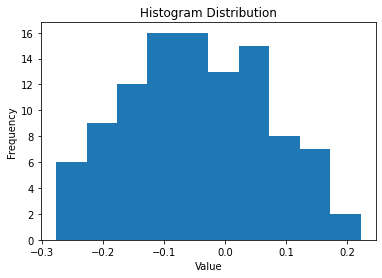

In [54]:
import matplotlib.pyplot as plt

# create a histogram of the values with 10 bins
plt.hist(output_values, bins= (len(output_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()


## Histogram for All The Dataset.

In [ ]:
import matplotlib.pyplot as plt

folder_output_values = []
for file_name in os.listdir(dataset_path):
  file_path = os.path.join(dataset_path, file_name)
  if os.path.isfile(file_path) and file_path.endswith(('.jpg', '.png', '.jpeg', '.webp')):
    with torch.no_grad():
      v_a = my_model( torch.tensor(np.array(compute_clip(Image.open(file_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
      folder_output_values.append(v_a.detach().numpy()[0][0])


# create a histogram of the values with 10 bins
plt.hist(folder_output_values, bins= (len(folder_output_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()


## Testing The Model On Two Random Images

In [56]:
random_images_values = []

def get_two_random_images():
  global dataset_path
  list_of_images = [os.path.join(dataset_path, file_name) for file_name in os.listdir(dataset_path) if file_name.endswith(('.png', '.jpeg', '.jpg', 'webp'))]
  return list_of_images[random.randint(0, len(list_of_images))] , list_of_images[random.randint(0, len(list_of_images))]


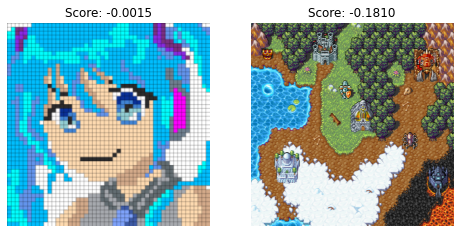

In [71]:
import matplotlib.pyplot as plt
from PIL import Image


first_image_path, second_image_path = get_two_random_images()

with torch.no_grad():
  v_a = my_model( torch.tensor(np.array(compute_clip(Image.open(first_image_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
  v_b = my_model( torch.tensor(np.array(compute_clip(Image.open(second_image_path)).detach().numpy()), dtype= torch.float32, requires_grad=False))
  random_images_values.append(v_a.detach().numpy()[0][0])
  random_images_values.append(v_b.detach().numpy()[0][0])
  

# create a figure with two subplots, and set their titles
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.set_title(f'Score: {v_a.detach().numpy()[0][0]:.4f}') 
ax2.set_title(f'Score: {v_b.detach().numpy()[0][0]:.4f}')
ax1.imshow(Image.open(first_image_path).resize((300, 300), resample=Image.BILINEAR))
ax1.axis('off')
ax2.imshow(Image.open(second_image_path).resize((300, 300), resample=Image.BILINEAR))
ax2.axis('off')
plt.show()



## Histogram for Random Images

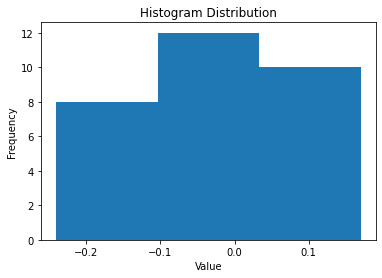

In [72]:
# create a histogram of the values with 10 bins
plt.hist(random_images_values, bins= (len(random_images_values)//10))

# set the title and labels for the histogram
plt.title('Histogram Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# show the histogram
plt.show()